Iñigo Martin Melero

## Participante 14

Hacemos a lo que se refieren algunos papers. Nuestros datos de entrada son:

- Fisiológico: 2500000 elementos, medido milisegundo a milisegundo. 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10...
- Joystick: 40000 elementos, medido de 50 milisegundos en 50 milisegundos. 0, 50, 100, 150...

Cambiaremos los dataset de entrada para partir en igualdad de condiciones a los papers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
from scipy import pi
from scipy.fftpack import rfft, rfftfreq

Leemos el csv del Joystick, y lo representamos.

In [2]:
df1=pd.read_csv('Bruto/sub_14_annotations.csv')
df1=df1.rename(columns={"jstime": "time"})
print(df1)

          time  valence  arousal  video
0            0      5.0    5.000     10
1           50      5.0    5.000     10
2          100      5.0    5.000     10
3          150      5.0    5.000     10
4          200      5.0    5.000     10
...        ...      ...      ...    ...
49027  2451350      5.0    5.003     12
49028  2451400      5.0    5.003     12
49029  2451450      5.0    5.003     12
49030  2451500      5.0    5.003     12
49031  2451550      5.0    5.003     12

[49032 rows x 4 columns]


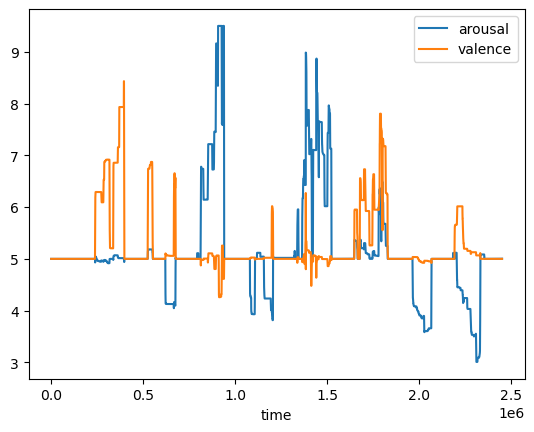

In [3]:
df1.plot(x="time", y=["arousal","valence"])
plt.show()

Leemos el csv de las variables Fisiológicas, y las representamos.

In [4]:
df2=pd.read_csv('Bruto/sub_14_physiological.csv')
df2=df2.rename(columns={"daqtime": "time"})
length_orig_df2=len(df2)
print(df2)

            time    ecg     bvp     gsr     rsp     skt  emg_zygo  emg_coru  \
0              0  0.915  37.165  29.441  32.663  25.943     7.619     8.112   
1              1  0.882  37.194  29.631  32.605  25.922     7.372     7.866   
2              2  0.850  37.223  29.820  32.547  25.901     7.126     7.619   
3              3  0.817  37.252  30.009  32.489  25.880     6.880     7.373   
4              4  0.826  36.965  29.761  32.498  25.887     6.918     7.492   
...          ...    ...     ...     ...     ...     ...       ...       ...   
2451579  2451579  0.685  36.820  26.971  31.946  24.870     5.234     5.850   
2451580  2451580  0.688  36.960  27.081  31.908  24.860     5.153     5.851   
2451581  2451581  0.688  37.058  26.957  31.898  24.867     5.153     5.810   
2451582  2451582  0.688  37.087  27.096  31.927  24.870     5.153     5.810   
2451583  2451583  0.692  36.867  26.961  31.927  24.867     5.112     5.810   

         emg_trap  video  
0          17.270     10

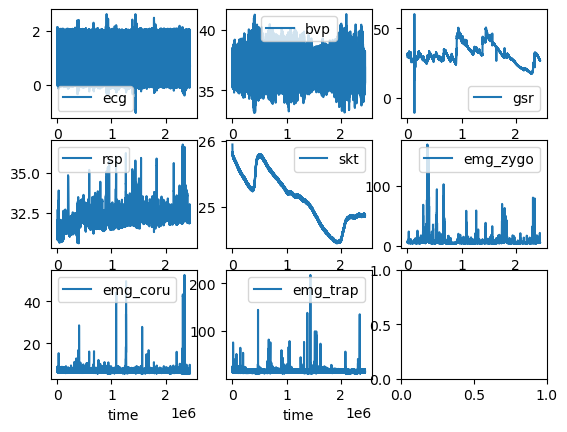

In [5]:
#define subplot layout
fig, axes = plt.subplots(nrows=3, ncols=3)

#add DataFrames to subplots
df2.plot(ax=axes[0,0],x="time",y="ecg")
df2.plot(ax=axes[0,1],x="time",y="bvp")
df2.plot(ax=axes[0,2],x="time",y="gsr")
df2.plot(ax=axes[1,0],x="time",y="rsp")
df2.plot(ax=axes[1,1],x="time",y="skt")
df2.plot(ax=axes[1,2],x="time",y="emg_zygo")
df2.plot(ax=axes[2,0],x="time",y="emg_coru")
df2.plot(ax=axes[2,1],x="time",y="emg_trap")
plt.show()

<AxesSubplot:xlabel='time'>

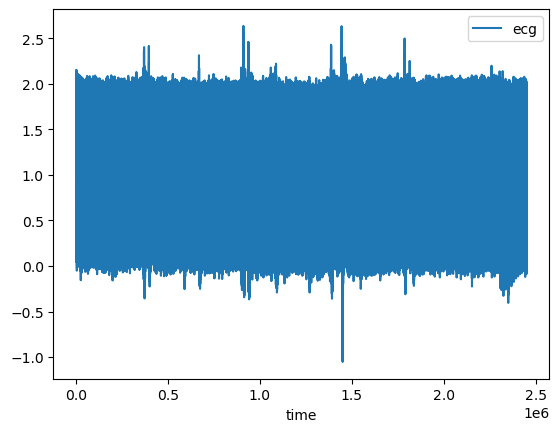

In [6]:
df2.plot(x="time",y="ecg")

<AxesSubplot:xlabel='time'>

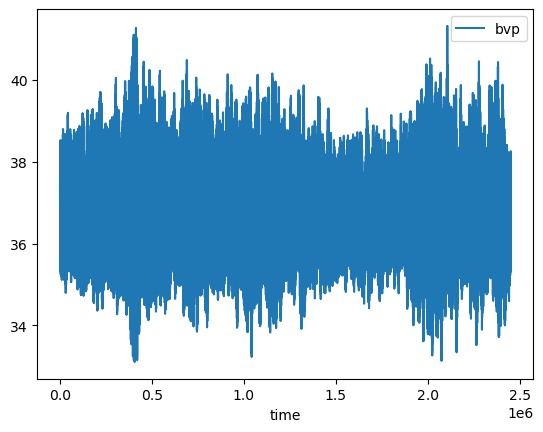

In [7]:
df2.plot(x="time",y="bvp")

<AxesSubplot:xlabel='time'>

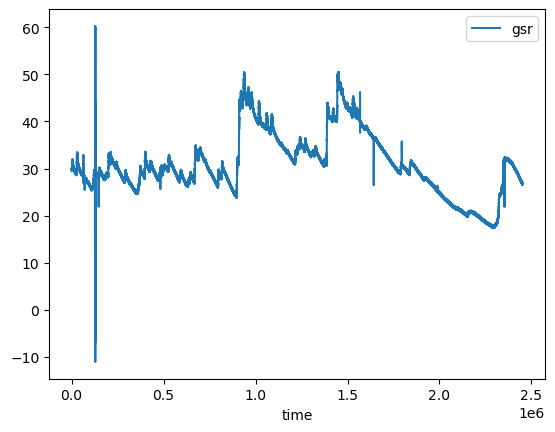

In [8]:
df2.plot(x="time",y="gsr")

<AxesSubplot:xlabel='time'>

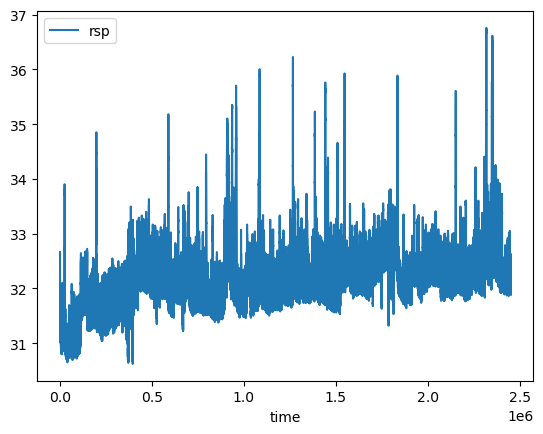

In [9]:
df2.plot(x="time",y="rsp")

<AxesSubplot:xlabel='time'>

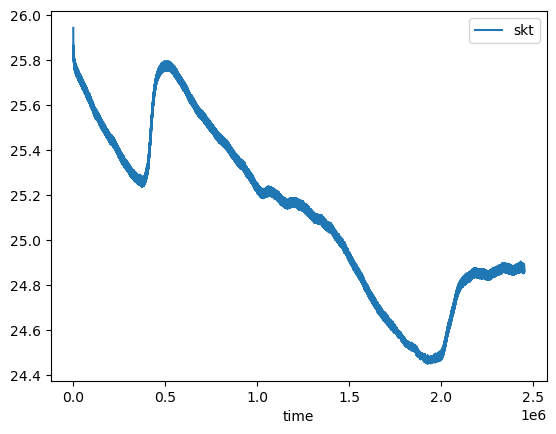

In [10]:
df2.plot(x="time",y="skt")


<AxesSubplot:xlabel='time'>

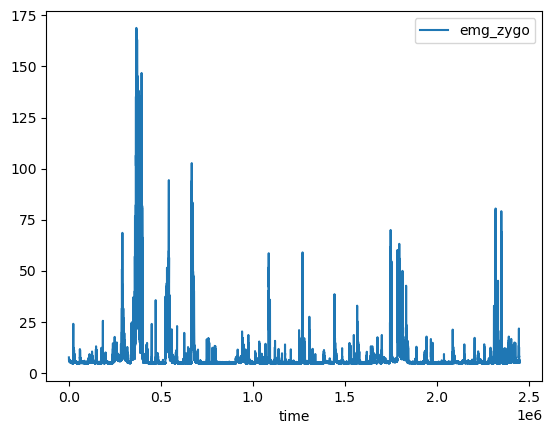

In [11]:
df2.plot(x="time",y="emg_zygo")


<AxesSubplot:xlabel='time'>

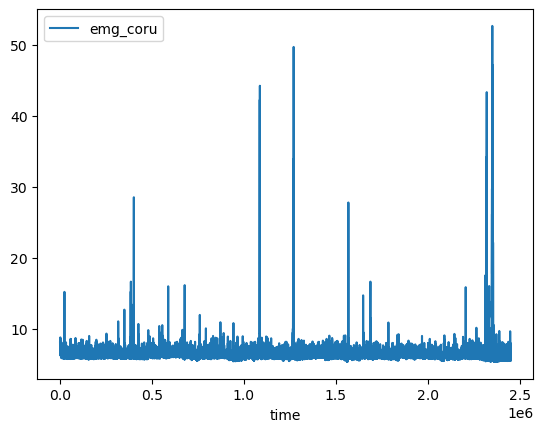

In [12]:
df2.plot(x="time",y="emg_coru")

<AxesSubplot:xlabel='time'>

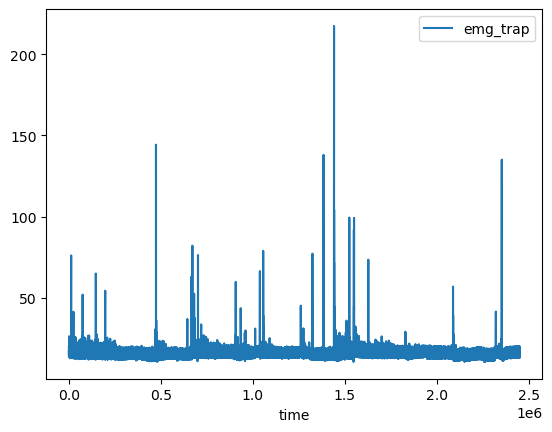

In [13]:
df2.plot(x="time",y="emg_trap")

El paper más completo que trata esto es CorrNet, donde se hace:

"Since the sampling rates of V-A and signals are 20 and 1000 Hz
respectively, we down-sampled all the signals to 50 Hz by decimation down-sampling. The EDA signals were
first filtered using a low pass filter with a 2 Hz cutoff frequency to remove noise.
For the BVP signal, we pre-processed it with a four-order butterworth bandpass filter with
cutoff frequencies [30, 200] Hz to eliminate the bursts. An elliptic band-pass filter
with cutoff frequencies [0.005, 0.1] was used to filter the ST signal. We followed the
standard filtering procedure widely used in previous works to pre-process the
physiological signals. Then the filtered signals are segmented into 2-second (sample size:
100 for CASE) instances."

O sea:

A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

D) Se normalizan las señales a 0 - 1, segun Min - Max.

E) Se busca la frecuencia en común de ambos a 50 Hz. Se hizo un estudio y fue la solución de compromiso.

F) Se utilizan ventanas de 2 segundos.

Lo vamos haciendo poco a poco.

    A) Se pasa filtro paso bajo 2 Hz a señales EDA (GSR).

<AxesSubplot:>

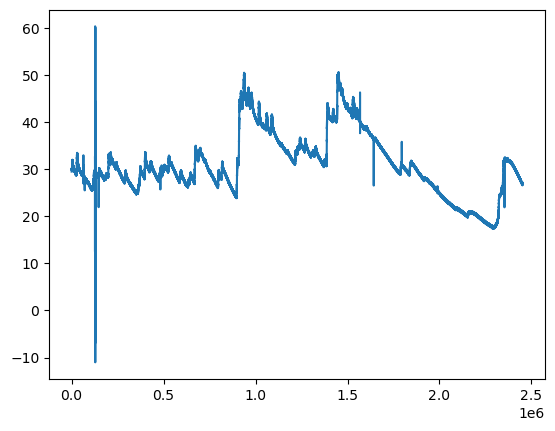

In [14]:
gsr_signal_notfiltered=df2['gsr']
gsr_signal_notfiltered.plot()

Representamos la senal en el dominio de la frecuencia. Vemos que hay frecuencias hasta el 500. Las querremos quitar todas menos las menores a 2 Hz. 

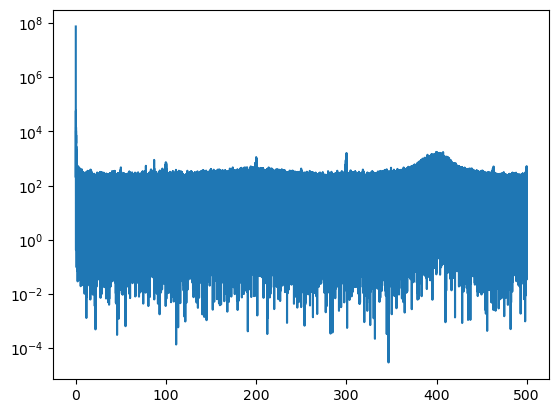

In [15]:
yf = rfft(gsr_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

In [16]:
lowpassfilter=signal.butter(N=10, Wn=2, btype='lp', fs=1000, output='sos')
gsr_filtered = signal.sosfilt(lowpassfilter, gsr_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias a partir de los 2 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente las frecuencias mayores a 2 Hz. 

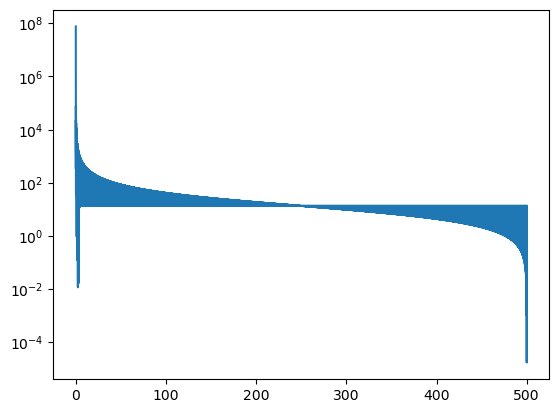

In [17]:
yf = rfft(gsr_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

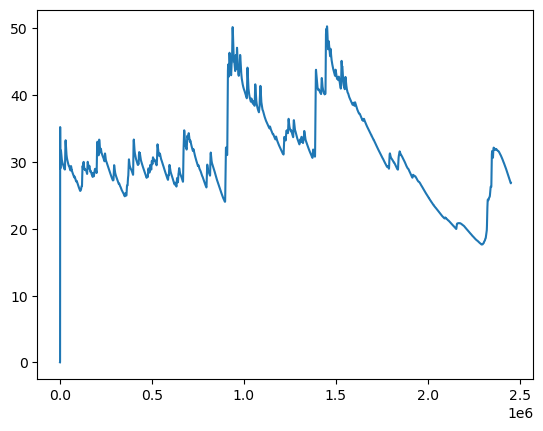

In [18]:
plt.plot(gsr_filtered)

In [19]:
gsr_signal_filtered = pd.DataFrame(gsr_filtered)
gsr_signal_filtered=gsr_signal_filtered.round(3)
gsr_signal_filtered=gsr_signal_filtered.rename(columns={0: "gsr"})
gsr_signal_filtered

gsr
0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
...         ...
2451579  26.878
2451580  26.878
2451581  26.878
2451582  26.879
2451583  26.879

[2451584 rows x 1 columns]

B) Se pasa filtro de cuarto orden butterworth con frecuencias corte [30, 200] Hz a señal BVP.

<AxesSubplot:>

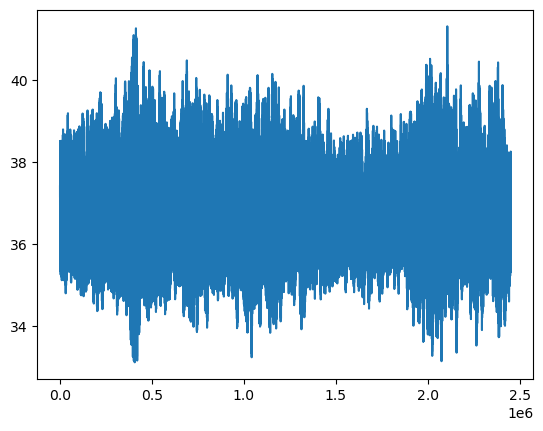

In [20]:
bvp_signal_notfiltered=df2['bvp']
bvp_signal_notfiltered.plot()

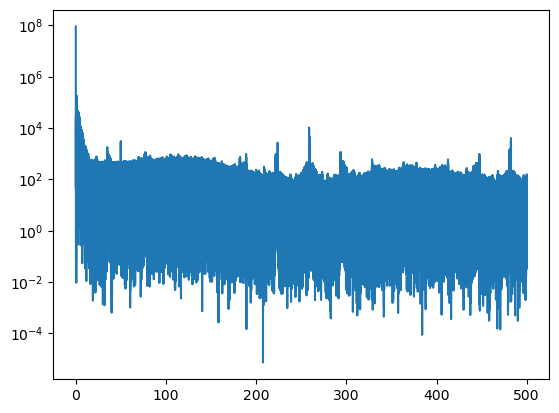

In [21]:
yf = rfft(bvp_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos el filtro Butter con frecuencias de corte de 30 a 200 Hz, de cuarto orden. Es un filtro paso banda.

In [22]:
butterfilter=signal.butter(N=4, Wn=[30,200], btype='bandpass', fs=1000, output='sos')
bvp_filtered = signal.sosfilt(butterfilter, bvp_signal_notfiltered)

Comprobamos la senal filtrada. No deberia tener (o tener amplitud muy reducida) en las frecuencias menores de 30 Hz y mayores a 200 Hz. Efectivamente vemos que se ha hecho lo mejor que se ha podido, y se han reducido notablemente esas frecuencias.

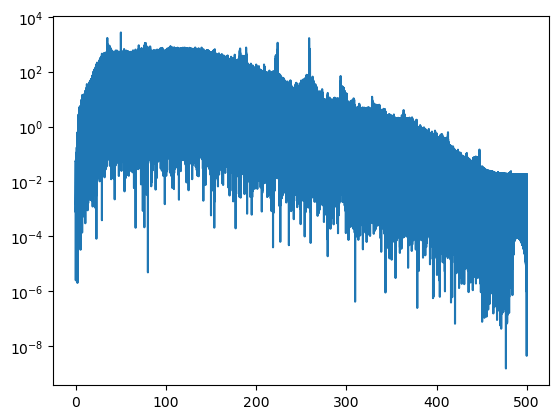

In [23]:
yf = rfft(bvp_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

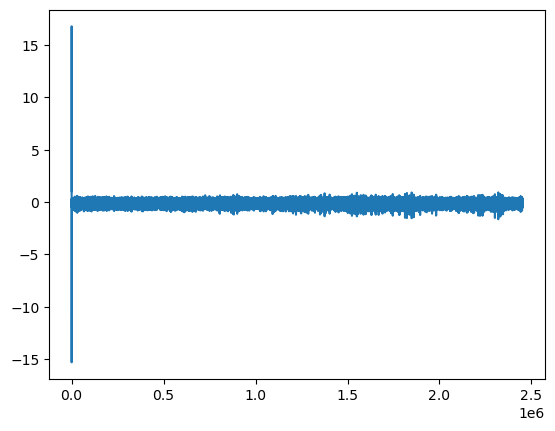

In [24]:
plt.plot(bvp_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [25]:
bvp_signal_filtered = pd.DataFrame(bvp_filtered)
bvp_signal_filtered=bvp_signal_filtered.round(3)
bvp_signal_filtered=bvp_signal_filtered.rename(columns={0: "bvp"})
bvp_signal_filtered=bvp_signal_filtered.add(37)
bvp_signal_filtered

bvp
0        38.033
1        42.762
2        50.560
3        53.776
4        46.395
...         ...
2451579  36.992
2451580  36.996
2451581  36.948
2451582  36.902
2451583  36.929

[2451584 rows x 1 columns]

    C) Se utiliza un filtro de paso eliptico con frecuencias corte [0.005, 0.1] a señal ST (SKT).

<AxesSubplot:>

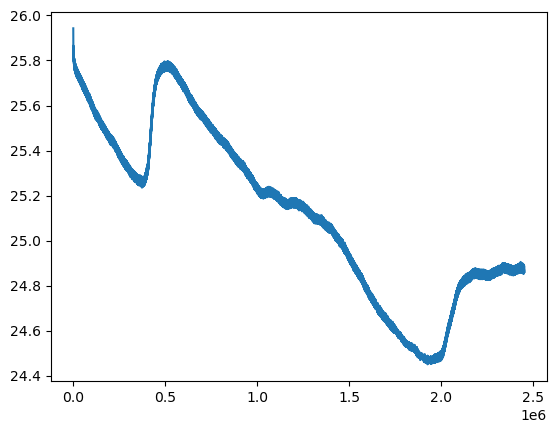

In [26]:
skt_signal_notfiltered=df2['skt']
skt_signal_notfiltered.plot()

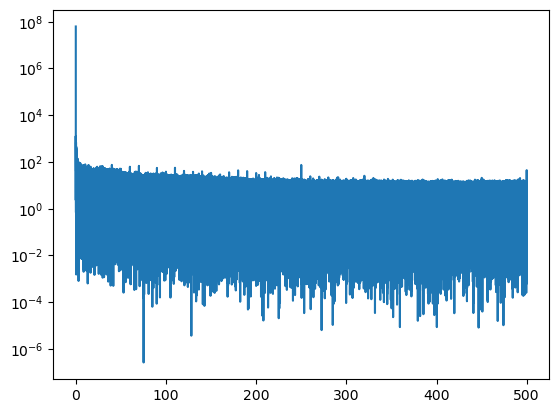

In [27]:
yf = rfft(skt_signal_notfiltered.values)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

Configuramos nuestro filtro eliptico con frecuencias corte [0.005, 0.1] a señal skt.

In [28]:
ellipticfilter=signal.ellip(N=4,rp=1, rs=1, Wn=[0.005,0.1], btype='bandpass', fs=1000, output='sos')
skt_filtered = signal.sosfilt(ellipticfilter, skt_signal_notfiltered)

Comprobamos la senal filtrada. Algo ha filtrado.

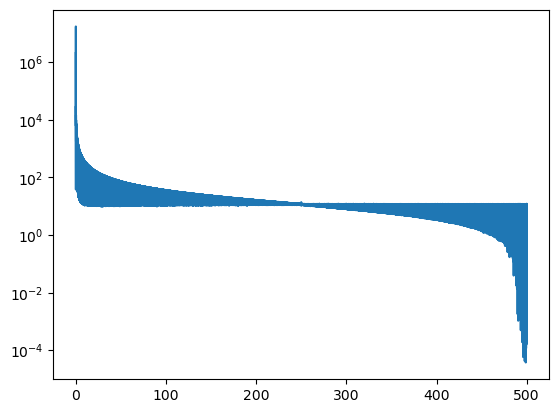

In [29]:
yf = rfft(skt_filtered)
xf = rfftfreq(2451584, 1/1000)
plt.plot(xf, np.abs(yf))
plt.yscale('log')
plt.show()

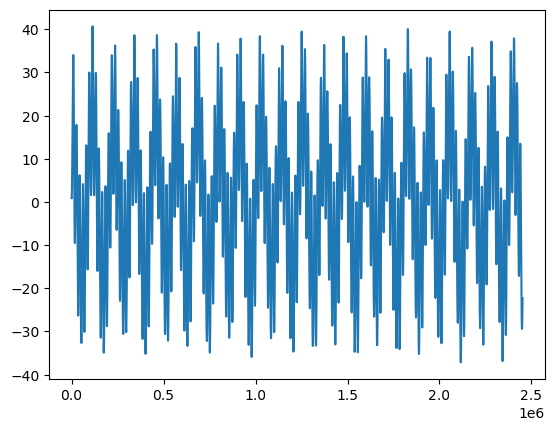

In [30]:
plt.plot(skt_filtered)

Vemos que el paso banda está centrado en el 0, por lo que lo offseteamos a arriba. Este problema le pasa a más gente, así que no pasa nada. Luego, como normalizaremos los datos, este efecto se eliminará lo offseteemos lo que lo offseteemos.

In [31]:
skt_signal_filtered = pd.DataFrame(skt_filtered)
skt_signal_filtered=skt_signal_filtered.round(3)
skt_signal_filtered=skt_signal_filtered.rename(columns={0: "skt"})
skt_signal_filtered=skt_signal_filtered.add(40)
skt_signal_filtered

skt
0        40.831
1        40.831
2        40.830
3        40.829
4        40.830
...         ...
2451579  17.709
2451580  17.713
2451581  17.718
2451582  17.722
2451583  17.726

[2451584 rows x 1 columns]

D) Se normalizan las senales.

Antes de normalizarlas, vamos a borrar las primeras 5000, ya que por los filtrados los principios de las senales son un poco raros. Borramos las columnas que acabamos de tunear del dataframe con todo.

In [32]:
df2=df2.drop(columns=["skt","bvp","gsr"])
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video
0              0  0.915  32.663     7.619     8.112    17.270     10
1              1  0.882  32.605     7.372     7.866    17.064     10
2              2  0.850  32.547     7.126     7.619    16.859     10
3              3  0.817  32.489     6.880     7.373    16.654     10
4              4  0.826  32.498     6.918     7.492    16.692     10
...          ...    ...     ...       ...       ...       ...    ...
2451579  2451579  0.685  31.946     5.234     5.850    13.777     12
2451580  2451580  0.688  31.908     5.153     5.851    13.736     12
2451581  2451581  0.688  31.898     5.153     5.810    13.695     12
2451582  2451582  0.688  31.927     5.153     5.810    13.695     12
2451583  2451583  0.692  31.927     5.112     5.810    13.695     12

[2451584 rows x 7 columns]

In [33]:
df2=pd.concat([df2, bvp_signal_filtered, gsr_signal_filtered,skt_signal_filtered], axis=1)
df2

time    ecg     rsp  emg_zygo  emg_coru  emg_trap  video     bvp  \
0              0  0.915  32.663     7.619     8.112    17.270     10  38.033   
1              1  0.882  32.605     7.372     7.866    17.064     10  42.762   
2              2  0.850  32.547     7.126     7.619    16.859     10  50.560   
3              3  0.817  32.489     6.880     7.373    16.654     10  53.776   
4              4  0.826  32.498     6.918     7.492    16.692     10  46.395   
...          ...    ...     ...       ...       ...       ...    ...     ...   
2451579  2451579  0.685  31.946     5.234     5.850    13.777     12  36.992   
2451580  2451580  0.688  31.908     5.153     5.851    13.736     12  36.996   
2451581  2451581  0.688  31.898     5.153     5.810    13.695     12  36.948   
2451582  2451582  0.688  31.927     5.153     5.810    13.695     12  36.902   
2451583  2451583  0.692  31.927     5.112     5.810    13.695     12  36.929   

            gsr     skt  
0         0.000  40.831  
1         0.000  40.831  
2         0.000  40.830  
3         0.000  40.829  
4         0.000  40.830  
...         ...     ...  
2451579  26.878  17.709  
2451580  26.878  17.713  
2451581  26.878  17.718  
2451582  26.879  17.722  
2451583  26.879  17.726  

[2451584 rows x 10 columns]

Tras aclarar esto, ya pasamos a normalizar. Antes, quitamos los videos que van al train, para que se normalicen solo los datos que van a ser entrenados realmente (sin los videos de BlueScreen, EndVid y StartVid).

In [34]:
df2 = df2[df2.video != 10]
df2 = df2[df2.video != 11]
df2 = df2[df2.video != 12]
scaler = MinMaxScaler()
scaler.fit(df2)
normalized = pd.DataFrame(scaler.transform(df2), index=df2.index, columns=df2.columns)
df2_normalized = pd.DataFrame(normalized, columns=df2.columns)
df2_normalized=df2_normalized.drop(columns=["video","time"])
numvideo_bien = df2["video"] 
tiempo_bien=df2["time"] 
df2_normalized=df2_normalized.join(numvideo_bien)
df2_normalized=df2_normalized.join(tiempo_bien)
df2=df2_normalized[["time","ecg","bvp","gsr","skt","rsp","emg_zygo","emg_coru","emg_trap","video"]]
df2

time       ecg       bvp       gsr       skt       rsp  emg_zygo  \
221501    221501  0.469233  0.652361  0.438200  0.775078  0.175605  0.002743   
221502    221502  0.468420  0.667577  0.438200  0.774997  0.175605  0.002487   
221503    221503  0.471944  0.692938  0.438200  0.774916  0.175605  0.002737   
221504    221504  0.470317  0.719469  0.438200  0.774849  0.180347  0.002986   
221505    221505  0.468420  0.731565  0.438230  0.774768  0.181982  0.003479   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.540526  0.615685  0.211344  0.337153  0.250000  0.003734   
2331580  2331580  0.545134  0.652361  0.211344  0.337234  0.248528  0.002992   
2331581  2331581  0.545134  0.663285  0.211344  0.337315  0.246893  0.002986   
2331582  2331582  0.544050  0.651970  0.211344  0.337396  0.248365  0.002986   
2331583  2331583  0.545947  0.648849  0.211344  0.337477  0.248365  0.002986   

         emg_coru  emg_trap  video  
221501   0.020123  0.035741      2  
221502   0.020123  0.035543      2  
221503   0.020123  0.035152      2  
221504   0.023270  0.035930      2  
221505   0.024354  0.036138      2  
...           ...       ...    ...  
2331579  0.012719  0.016082      5  
2331580  0.010629  0.016280      5  
2331581  0.012693  0.016280      5  
2331582  0.011661  0.016478      5  
2331583  0.008513  0.016676      5  

[1270083 rows x 10 columns]

    E) Frecuencia común 50 Hz

Para la frecuencia comun a ambos, ello implica tener lecturas cada 1/50 = 20 ms. Para las senales fisiologicas lo tenemos, pero para las annotations no, por lo que hay que resample. Primero resampleamos a que nos saque todos los valores por milisegundo de annotations, y luego downsampleamos para quedarnos solo con los que sean menores a 20 ms. 

In [35]:
n_samples=length_orig_df2
df1_clean=df1.drop(columns=['time', 'video'])
array1_resampled=signal.resample(df1_clean, n_samples)
df1_resampled=pd.DataFrame(array1_resampled,columns=["valence","arousal"])
df1_resampled=df1_resampled.round(3)
print(df1_resampled)

         valence  arousal
0            5.0      5.0
1            5.0      5.0
2            5.0      5.0
3            5.0      5.0
4            5.0      5.0
...          ...      ...
2451579      5.0      5.0
2451580      5.0      5.0
2451581      5.0      5.0
2451582      5.0      5.0
2451583      5.0      5.0

[2451584 rows x 2 columns]


Unimos los csv, con columna intersección en "time". Borramos los instantes de tiempo X e Y porque en realidad no son necesarios. Reordenamos las columnas.

In [36]:
df3=pd.merge(df1_resampled, df2, left_index=True, right_index=True)

columnsTitles = ['time', 'ecg', 'bvp','gsr','rsp','skt','emg_zygo','emg_coru','emg_trap','valence','arousal','video']
df3 = df3.reindex(columns=columnsTitles)

print(df3)

            time       ecg       bvp       gsr       rsp       skt  emg_zygo  \
221501    221501  0.469233  0.652361  0.438200  0.175605  0.775078  0.002743   
221502    221502  0.468420  0.667577  0.438200  0.175605  0.774997  0.002487   
221503    221503  0.471944  0.692938  0.438200  0.175605  0.774916  0.002737   
221504    221504  0.470317  0.719469  0.438200  0.180347  0.774849  0.002986   
221505    221505  0.468420  0.731565  0.438230  0.181982  0.774768  0.003479   
...          ...       ...       ...       ...       ...       ...       ...   
2331579  2331579  0.540526  0.615685  0.211344  0.250000  0.337153  0.003734   
2331580  2331580  0.545134  0.652361  0.211344  0.248528  0.337234  0.002992   
2331581  2331581  0.545134  0.663285  0.211344  0.246893  0.337315  0.002986   
2331582  2331582  0.544050  0.651970  0.211344  0.248365  0.337396  0.002986   
2331583  2331583  0.545947  0.648849  0.211344  0.248365  0.337477  0.002986   

         emg_coru  emg_trap  valence  a

Downsampleamos a 20 ms y eliminamos la columna tiempo. 

In [37]:
df3 = df3.drop(df3[df3.time%20 != 0].index)
df3 = df3.drop(columns=['time'])
print(df3)

              ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
221520   0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
221540   0.472757  0.646898  0.438322  0.180347  0.772082  0.001989  0.015918   
221560   0.473841  0.658213  0.438383  0.189830  0.770557  0.002731  0.021155   
221580   0.473028  0.633242  0.438414  0.193100  0.769018  0.003235  0.021181   
221600   0.474654  0.653531  0.438475  0.196207  0.767479  0.002992  0.020149   
...           ...       ...       ...       ...       ...       ...       ...   
2331500  0.513960  0.629341  0.211038  0.250000  0.330593  0.002238  0.007404   
2331520  0.519111  0.660554  0.211100  0.245258  0.332240  0.002487  0.010603   
2331540  0.521008  0.678112  0.211191  0.242152  0.333900  0.002232  0.010577   
2331560  0.530767  0.630121  0.211253  0.242152  0.335574  0.002487  0.009520   
2331580  0.545134  0.652361  0.211344  0.248528  0.337234  0.002992  0.010629   

         emg_trap  valence 

Creamos la ventana de n = 2 segundos. Una ventana de datos simplemente será concatenar los datos dentro de grupos de 2 segundos, haciendo la media de valencia y de arousal de todos ellos. 

Como la frecuencia de muestreo son 20 ms, cada ventana de 2 segundos tendrá en total 100 observaciones. Después, esto lo "flattenaremos" para que el modelo ML en R pueda tragarlo.  

En primer lugar, como las ventanas son de 2 segundos, eliminamos un número de datos para que nos den las ventanas justas. Tendríamos varios criterios:

- A) Ver en el completo de los datos las entradas que tenemos múltiplos de 100 (ventanas de 2 s), y eliminar del múltiplo más alto hasta el final.

- B) Algo más fino quizá sería hacer lo mismo pero video a video. 

Por simplicidad y ver lo que sale hacemos A). Comenzamos creando un nuevo indice desde 0 del Dataframe que tenemos y borramos el valor del video. 

In [38]:
df3 = df3.drop(columns=['video'])
df3 = df3.reset_index()
df3 = df3.drop(columns=['index'])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1      0.472757  0.646898  0.438322  0.180347  0.772082  0.001989  0.015918   
2      0.473841  0.658213  0.438383  0.189830  0.770557  0.002731  0.021155   
3      0.473028  0.633242  0.438414  0.193100  0.769018  0.003235  0.021181   
4      0.474654  0.653531  0.438475  0.196207  0.767479  0.002992  0.020149   
...         ...       ...       ...       ...       ...       ...       ...   
63499  0.513960  0.629341  0.211038  0.250000  0.330593  0.002238  0.007404   
63500  0.519111  0.660554  0.211100  0.245258  0.332240  0.002487  0.010603   
63501  0.521008  0.678112  0.211191  0.242152  0.333900  0.002232  0.010577   
63502  0.530767  0.630121  0.211253  0.242152  0.335574  0.002487  0.009520   
63503  0.545134  0.652361  0.211344  0.248528  0.337234  0.002992  0.010629   

       emg_trap  valence  arousal  
0      0.030577    5.000    5.000  
1      0.025825    5.000    5.000  
2      0.017677    5.000    5.000  
3      0.016478    5.000    5.000  
4      0.014887    5.000    5.000  
...         ...      ...      ...  
63499  0.037932    5.067    3.236  
63500  0.024621    5.067    3.243  
63501  0.018659    5.067    3.248  
63502  0.016483    5.067    3.252  
63503  0.016280    5.067    3.255  

[63504 rows x 10 columns]

Como tenemos 63504 filas, necesitamos borrar solo las ultimas 4.

In [39]:
df3=df3.drop([63503, 63502, 63501, 63500])
df3

ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
0      0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1      0.472757  0.646898  0.438322  0.180347  0.772082  0.001989  0.015918   
2      0.473841  0.658213  0.438383  0.189830  0.770557  0.002731  0.021155   
3      0.473028  0.633242  0.438414  0.193100  0.769018  0.003235  0.021181   
4      0.474654  0.653531  0.438475  0.196207  0.767479  0.002992  0.020149   
...         ...       ...       ...       ...       ...       ...       ...   
63495  0.485497  0.623878  0.210702  0.246893  0.323912  0.002487  0.008462   
63496  0.724044  0.651190  0.210794  0.250000  0.325586  0.002737  0.010577   
63497  0.532123  0.681233  0.210855  0.248365  0.327259  0.002725  0.008436   
63498  0.360531  0.618026  0.210947  0.243623  0.328920  0.001989  0.006372   
63499  0.513960  0.629341  0.211038  0.250000  0.330593  0.002238  0.007404   

       emg_trap  valence  arousal  
0      0.030577    5.000    5.000  
1      0.025825    5.000    5.000  
2      0.017677    5.000    5.000  
3      0.016478    5.000    5.000  
4      0.014887    5.000    5.000  
...         ...      ...      ...  
63495  0.017073    5.067    3.205  
63496  0.016478    5.067    3.210  
63497  0.020245    5.067    3.218  
63498  0.027778    5.067    3.227  
63499  0.037932    5.067    3.236  

[63500 rows x 10 columns]

Y ahora si, con split dividimos el Dataset en 635 entradas de 100 datos cada una. 

In [40]:
df3_split_2s = np.array_split(df3, len(df3)/25)
df3_split_2s

[         ecg       bvp       gsr       rsp       skt  emg_zygo  emg_coru  \
 0   0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
 1   0.472757  0.646898  0.438322  0.180347  0.772082  0.001989  0.015918   
 2   0.473841  0.658213  0.438383  0.189830  0.770557  0.002731  0.021155   
 3   0.473028  0.633242  0.438414  0.193100  0.769018  0.003235  0.021181   
 4   0.474654  0.653531  0.438475  0.196207  0.767479  0.002992  0.020149   
 5   0.490648  0.617636  0.438536  0.199477  0.765927  0.002737  0.020149   
 6   0.487937  0.635193  0.438567  0.202583  0.764388  0.002487  0.020149   
 7   0.487124  0.667577  0.438628  0.205690  0.762836  0.002493  0.018033   
 8   0.476552  0.662505  0.438659  0.215173  0.761297  0.003479  0.021206   
 9   0.464896  0.644167  0.438720  0.212067  0.759745  0.003241  0.022264   
 10  0.473841  0.648459  0.438751  0.218443  0.758193  0.003728  0.024354   
 11  0.470317  0.601639  0.438781  0.219915  0.756641  0.003485  0.022264   

Ahora, realizaremos el Flatteneado. Las matrices las haremos una linea continua: pasamos de tener 100 observaciones de 8 variables a tener 1 observacion de 800 variables. 
Creamos el Dataframe que nos contenga todo, que tendrá 800 variables + Valence + Arousal (802 en total). Le ponemos nombre a las columnas del Dataframe solamente porque no se puede crear un Dataframe sin columnas, sino solo nos importaría llamar a la de Valence y Arousal.  

In [41]:
list_array = list(np.arange(1,201))
list_array.append("valence")
list_array.append("arousal")
df4 = pd.DataFrame(columns=list_array)
df4

Empty DataFrame
Columns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...]
Index: []

[0 rows x 202 columns]

Y ahora hago el proceso de hacer el flatenning, y obtener el nuevo Dataframe con la ventana aplicada que exportaremos. Lo hacemos con un for para que repase todas las agrupaciones de 8 x 100 datos. De cada ventana calculamos (según papers) la valence y arousal promedios, y eso lo anadiremos en las ultimas dos columnas). 

In [42]:
for entrada in df3_split_2s:
    ave_valence=entrada['valence'].mean()
    ave_arousal=entrada['arousal'].mean()
    entrada=entrada.drop(columns=['valence','arousal'])
    a=entrada.to_numpy().flatten()
    a=np.append(a, ave_valence)
    a=np.append(a, ave_arousal)
    df4.loc[len(df4)] = a

In [43]:
df4

1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       193       194       195  \
0     0.030577  0.472757  0.646898  ...  0.621578  0.644947  0.438934   
1     0.015680  0.654649  0.656652  ...  0.466793  0.635193  0.438077   
2     0.020656  0.471944  0.651970  ...  0.673353  0.644167  0.435997   
3     0.017469  0.597723  0.640265  ...  0.479263  0.657823  0.433366   
4     0.015685  0.480076  0.640655  ...  0.681214  0.664846  0.430001   
...        ...       ...       ...  ...       ...       ...       ...   
2535  0.015883  0.528056  0.658993  ...  0.467606  0.615295  0.204093   
2536  0.015685  0.477365  0.672649  ...  0.541610  0.677331  0.205287   
2537  0.016280  0.493359  0.600468  ...  0.482787  0.640265  0.206908   
2538  0.015879  0.474654  0.688646  ...  0.498780  0.607881  0.209264   
2539  0.015685  0.492545  0.630121  ...  0.513960  0.629341  0.211038   

           196       197       198       199       200  valence  arousal  
0     0.238882  0.736314  0.003229  0.021155  0.012504    5.000  5.00000  
1     0.180347  0.697184  0.002238  0.021206  0.034953    5.000  5.00000  
2     0.117070  0.659108  0.002238  0.019065  0.017078    5.000  5.00000  
3     0.091727  0.623218  0.001983  0.018033  0.016483    5.000  5.00000  
4     0.085513  0.590420  0.002238  0.020149  0.023436    5.000  5.00000  
...        ...       ...       ...       ...       ...      ...      ...  
2535  0.246893  0.174617  0.004987  0.012719  0.016280    5.067  3.14216  
2536  0.235775  0.209386  0.003491  0.009545  0.015676    5.067  3.15556  
2537  0.245258  0.247908  0.003734  0.009545  0.015487    5.067  3.17192  
2538  0.243623  0.288832  0.003235  0.008462  0.015883    5.067  3.18228  
2539  0.250000  0.330593  0.002238  0.007404  0.037932    5.067  3.19816  

[2540 rows x 202 columns]

Para esta iteracion, analizamos los datos segun CorrNet. CorrNet propone 3 clasificaciones diferentes:
- Clasificación en 2 clases:
    
    Modelo ML A: Clasificamos Arousal en High y Low.
    
    Modelo ML B: Clasificamos Valence en High y Low. 


- Clasificación en 3 clases:
    
    Modelo ML C: Clasificamos Arousal en High, Neutral y Low.
   
    Modelo ML D: Clasificamos Valence en High, Neutral y Low.
    
    
- Clasificación en 4 clases:
    
    Modelo ML E: Clasificamos Valence y Arousal en los cuatro cuadrantes: High High, High Low, Low Low y Low High. 
   
   
Para cada uno, realizamos un dataframe diferente. 

- Modelo A. Clasificamos Arousal en High y Low. High --> 2 y Low --> 1

In [44]:
df4_A = df4.drop(columns=['valence'])
df4_A=df4_A.rename(columns={"arousal": "auxiliar"})
df4_A.loc[df4_A['auxiliar'] < 5, 'arousal'] = 1
df4_A.loc[df4_A['auxiliar'] >= 5, 'arousal'] = 2
df4_A = df4_A.drop(columns=['auxiliar'])
print(df4_A)

             1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       192       193    

In [45]:
df4_A.to_csv('Output/arousal_2_clases_sub14.csv', index=False)

- Modelo B. Clasificamos Valence en High y Low. High --> 2 y Low --> 1

In [46]:
df4_B = df4.drop(columns=['arousal'])
df4_B=df4_B.rename(columns={"valence": "auxiliar"})
df4_B.loc[df4_B['auxiliar'] < 5, 'valence'] = 1
df4_B.loc[df4_B['auxiliar'] >= 5, 'valence'] = 2
df4_B = df4_B.drop(columns=['auxiliar'])
print(df4_B)

             1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       192       193    

In [47]:
df4_B.to_csv('Output/valence_2_clases_sub14.csv', index=False)

- Modelo C. Clasificamos Arousal en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [48]:
df4_C = df4.drop(columns=['valence'])
df4_C=df4_C.rename(columns={"arousal": "auxiliar"})
df4_C.loc[df4_C['auxiliar'] < 3, 'arousal'] = 1
df4_C.loc[(df4_C['auxiliar'] >= 3) & (df4_C['auxiliar'] < 6), 'arousal'] = 2
df4_C.loc[(df4_C['auxiliar'] >= 6), 'arousal'] = 3
df4_C = df4_C.drop(columns=['auxiliar'])
print(df4_C)

             1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       192       193    

In [49]:
df4_C.to_csv('Output/arousal_3_clases_sub14.csv', index=False)

- Modelo D. Clasificamos Valence en High, Neutral y Low. High --> 3, Neutral --> 2 y Low --> 1

In [50]:
df4_D = df4.drop(columns=['arousal'])
df4_D=df4_D.rename(columns={"valence": "auxiliar"})
df4_D.loc[df4_D['auxiliar'] < 3, 'valence'] = 1
df4_D.loc[(df4_D['auxiliar'] >= 3) & (df4_D['auxiliar'] < 6), 'valence'] = 2
df4_D.loc[(df4_D['auxiliar'] >= 6), 'valence'] = 3
df4_D = df4_D.drop(columns=['auxiliar'])
print(df4_D)

             1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       192       193    

In [51]:
df4_D.to_csv('Output/valence_3_clases_sub14.csv', index=False)

- Modelo E. Clasificamos Valence y Arousal. Valence High y Arousal High --> 4, Valence High y Arousal Low --> 3, Valence Low y Arousal High --> 2, Valence Low y Arousal Low --> 1. 

In [52]:
df4_E = df4
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 1
df4_E.loc[(df4_E['valence'] <= 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 2
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] <= 5), 'valencearousal'] = 3
df4_E.loc[(df4_E['valence'] > 5) & (df4_E['arousal'] > 5), 'valencearousal'] = 4
df4_E = df4_E.drop(columns=['valence', 'arousal'])
print(df4_E)

             1         2         3         4         5         6         7  \
0     0.469233  0.661334  0.438261  0.181982  0.773621  0.002731  0.021181   
1     0.651938  0.643777  0.438904  0.235775  0.734748  0.002986  0.019065   
2     0.471130  0.609052  0.438016  0.178712  0.695646  0.002244  0.022238   
3     0.667932  0.644167  0.435875  0.109222  0.657623  0.001995  0.016975   
4     0.481702  0.619586  0.433213  0.093362  0.621842  0.001983  0.018007   
...        ...       ...       ...       ...       ...       ...       ...   
2535  0.521008  0.681233  0.203604  0.254742  0.145759  0.003983  0.009545   
2536  0.464896  0.647679  0.204093  0.243623  0.175912  0.004987  0.010577   
2537  0.500678  0.608662  0.205348  0.238882  0.210857  0.003740  0.008488   
2538  0.474654  0.633242  0.206969  0.246893  0.249514  0.003740  0.008513   
2539  0.492545  0.640265  0.209356  0.235775  0.290492  0.002238  0.007404   

             8         9        10  ...       192       193    

In [53]:
df4_E.to_csv('Output/valencearousal_4_clases_sub14.csv', index=False)